### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

import matplotlib.pyplot as plt
#%matplotlib widget

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

### 0 - Setting the random state

In [4]:
random_state = min(332078,328202)

In [5]:
random.seed(random_state)

## 1 - Loading and Preparing the Data

### 1.1 - Import the dataset

In [6]:
# Import csv
file_name = 'cla4lsp_customers.csv'
df_tot = pd.read_csv(file_name, sep='\t')

### 1.2 - Split dataset

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset
workdf, not_workdf = train_test_split(df_tot, test_size = 1/3, random_state=random_state)

In [8]:
# Save the dataframes
workdf.to_csv('working_dataset.csv')
not_workdf.to_csv('not_working_dataset.csv')

In [9]:
######
# Import the datasets
workdf = pd.read_csv('working_dataset.csv')
not_workdf = pd.read_csv('not_working_dataset.csv')
######

### 1.3 - Divide columns 

First of all, we divide the columns based on their purpose. 

We have features *('Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth')* 

and labels *('NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain', 'Recency')*

and some other columns that are useless for this analysis, which will just be dropped.

In [10]:
labels = ['NumDealsPurchases','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain','Recency']
features = ['Year_Birth','Education','Marital_Status','Income','Kidhome','Teenhome','Dt_Customer','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
other_columns = [col for col in workdf.columns if col not in (labels + features)]

In [11]:
# Drop unknown columns
workdf = workdf.drop(other_columns, axis=1)

In [12]:
workdf[labels].sum()

NumDealsPurchases     3533
AcceptedCmp1            98
AcceptedCmp2            15
AcceptedCmp3            97
AcceptedCmp4           113
AcceptedCmp5           110
Response               220
Complain                16
Recency              73084
dtype: int64

### 1.4 - Remove a random feature

Let's remove a random feature. Using the random seed set at the begininning of the analysis, *'NumStorePurchases'* is the dropped column.

In [13]:
purchasing_habits = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [14]:
# Removing random feature
random_pick = random.choice(purchasing_habits)
workdf = workdf.drop(random_pick, axis=1)
features.remove(random_pick)

In [15]:
random_pick

'NumStorePurchases'

### 1.5 - Data cleaning

Before beginning the encoding of the features, we had to clean the dataset from missing values. 

Luckly, we observed that only 16 values were missing, all in the feature *'Income'*. Since it is a small number compared to the total of datas, we just removed all the 16 clients with missing value for *'Income'*.

In [16]:
print(f' NaN elements from working set:\n{workdf.isna().sum()}')
print(f' \nNaN elements from NON working set:\n{not_workdf.isna().sum()}')

 NaN elements from working set:
Year_Birth              0
Education               0
Marital_Status          0
Income                 16
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64
 
NaN elements from NON working set:
Unnamed: 0             0
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 8
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines          

In [17]:
# Drop NaN values
workdf.dropna(inplace=True)
not_workdf.dropna(inplace=True)

In [18]:
workdf[labels].describe()

,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,Recency
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,2.368314,0.064997,0.010156,0.065674,0.075152,0.073798,0.148274,0.010833,48.810427
std,1.982245,0.246603,0.100297,0.247795,0.263726,0.261531,0.355491,0.103550,29.020119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000
75%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.000000


## 2 - Encoding of Categorical Data

Some features have categorical data, so, in order to work with those, we need to convert them. 

To encode '*MaritalStatus*', we used the 'One-Hot Encoding' method, which assign to each category ('Married', 'Single', 'Together', 'Divorced', 'Absurd', 'Alone', 'YOLO', 'Widow') a randomly distinct vector of the canonical base of $\mathbb{R}^{k}$, so we obtain 8 new features with only values 0 or 1 instead of the original feature. We decided to use this method because we did not need any order between categories and, even if the dimensionality of the problem increases, it is the most valuable way to encode that.

We actually needed an order to encode '*Education*', since there are different levels of education and that can definitely be useful for the analysis. So we decide to use another method of encoding, the 'Label Encoding', which ranks each category based on the level of education as it follows:
1. Basic
1. 2n Cycle
1. Graduation
1. Master
1. PhD

In [19]:
# Encode the Education feature with one hot encoding 
#workdf = pd.get_dummies(workdf, columns=['Education'])

dict = {'Graduation':3, 
        'PhD':5, 
        'Master':4, 
        '2n Cycle':2, 
        'Basic':1
}

workdf['Education'] = workdf['Education'].map(dict)


In [20]:
# Encode the Marital_Status feature with one hot encoding 
workdf = pd.get_dummies(workdf, columns=['Marital_Status'])

In [21]:
workdf = workdf.replace({True: 1, False: 0})

##### Osservazioni
- dopo aver applicato get_dummies() la colonna marital_status è stata droppata
- è possibile verificare la riuscita del one hot encoding sfruttando .sum() e facendo riferimento alla cella con la funzione values_count()

In [22]:
# Drop Dt_Customer column
workdf = workdf.drop(columns='Dt_Customer')

In [23]:
# Update features list
features = [feature for feature in workdf.columns if feature not in labels]

In [24]:
workdf.describe()

,Year_Birth,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Response,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,...,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,1968.832769,3.465132,52197.784699,0.452268,0.507109,48.810427,302.437373,25.949221,169.330399,38.074475,...,0.010833,0.148274,0.001354,0.002031,0.096818,0.383886,0.214624,0.264049,0.036561,0.000677
std,12.167577,0.995060,26658.477243,0.542181,0.541737,29.020119,333.023270,39.419597,227.352628,55.081350,...,0.103550,0.355491,0.036786,0.045038,0.295810,0.486495,0.410700,0.440975,0.187744,0.026020
min,1893.000000,1.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,3.000000,34916.000000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1970.000000,3.000000,51373.000000,0.000000,0.000000,49.000000,179.000000,8.000000,68.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1978.000000,4.000000,68655.000000,1.000000,1.000000,73.000000,493.000000,32.000000,238.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1996.000000,5.000000,666666.000000,2.000000,2.000000,99.000000,1492.000000,199.000000,1725.000000,258.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the description of the dataset, especially looking at the 75th percentile and the maximum value of the columns, we can see that the columns: 'Income' and 'Age' have some outliers.

In [25]:
# Define sub-df by selecting feature columns
Xworkdf = workdf[features]

In [26]:
features

['Year_Birth',
 'Education',
 'Income',
 'Kidhome',
 'Teenhome',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumWebVisitsMonth',
 'Marital_Status_Absurd',
 'Marital_Status_Alone',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Together',
 'Marital_Status_Widow',
 'Marital_Status_YOLO']

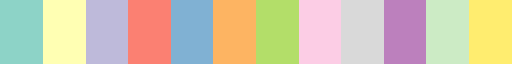

,feature,category,color
0,Year_Birth,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
1,Education,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
2,Income,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
3,Kidhome,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
4,Teenhome,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
5,MntWines,Amounts,"(1.0, 1.0, 0.7019607843137254)"
6,MntFruits,Amounts,"(1.0, 1.0, 0.7019607843137254)"
7,MntMeatProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"
8,MntFishProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"
9,MntSweetProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"


In [27]:

# Set the color for different categories of features

# dataframe with these columns [features, category, color]
set3 = cm.Set3.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set3)
#############################################################

data = {'feature': Xworkdf.columns}
feature_cat_df = pd.DataFrame(data)

cat_dict = {'Year_Birth': 'Personal_info', 
            'Income': 'Personal_info', 
            'Kidhome': 'Personal_info', 
            'Teenhome': 'Personal_info', 
            'MntWines': 'Amounts', 
            'MntFruits': 'Amounts',
            'MntMeatProducts': 'Amounts', 
            'MntFishProducts': 'Amounts', 
            'MntSweetProducts': 'Amounts',
            'MntGoldProds': 'Amounts', 
            'NumWebPurchases': 'Numbers', 
            'NumCatalogPurchases': 'Numbers',
            'NumStorePurchases':'Numbers',
            'NumWebVisitsMonth': 'Numbers', 
            'Education': 'Personal_info',
            'Marital_Status_Absurd': 'Personal_info',
            'Marital_Status_Alone': 'Personal_info',
            'Marital_Status_Divorced': 'Personal_info', 
            'Marital_Status_Married': 'Personal_info',
            'Marital_Status_Single': 'Personal_info', 
            'Marital_Status_Together': 'Personal_info',
            'Marital_Status_Widow': 'Personal_info', 
            'Marital_Status_YOLO': 'Personal_info'
}

feature_cat_df['category'] = pd.Series([cat_dict[t] for t in feature_cat_df['feature']])

cat_colors = {
    'Personal_info': set3[0],
    'Amounts': set3[1],
    'Numbers': set3[2],
}

feature_cat_df['color'] = feature_cat_df['category'].map(cat_colors)

display(feature_cat_df)

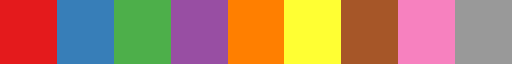

,NumDealsPurchases,color
0,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."
2,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."
3,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
4,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
...,...,...
1488,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1489,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1490,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1491,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."


In [28]:
# Set the color for different person wrt AcceptedCmp labels

set1 = cm.Set1.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set1)
#############################################################

# label of interest
interesting_labels = 'NumDealsPurchases'

label_df = pd.DataFrame(workdf['NumDealsPurchases'])

label_dict = {
    True: set1[0],  # Condition > 2
    False: set1[1]   # Condition <= 2
}
label_df['NumDealsPurchases'] = label_df['NumDealsPurchases'] > 2

label_df['color'] = label_df['NumDealsPurchases'].map(label_dict)

label_df

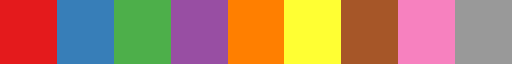

,Recency,NumDealsPurchases,color
0,60,1,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1,84,5,"(0.8941176470588236, 0.10196078431372549, 0.10..."
2,36,3,"(0.30196078431372547, 0.6862745098039216, 0.29..."
3,0,2,"(0.596078431372549, 0.3058823529411765, 0.6392..."
4,98,2,"(0.21568627450980393, 0.49411764705882355, 0.7..."
...,...,...,...
1488,26,2,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1489,29,1,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1490,20,1,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1491,33,4,"(0.30196078431372547, 0.6862745098039216, 0.29..."


In [30]:
import pandas as pd
import matplotlib.cm as cm
from IPython.display import display

# Assuming you have already defined set1
set1 = cm.Set1.colors

# Displaying the colors of the chosen colormap
display(cm.Set1)

label_df = pd.DataFrame(workdf[['Recency', 'NumDealsPurchases']])

# dict
label_dict = {
    (True, True): set1[0],    # NumDealsPurchases > 2 && Recency > 49
    (False, True): set1[1],   # NumDealsPurchases <= 2 && Recency > 49
    (True, False): set1[2],   # NumDealsPurchases > 2 && Recency <= 49
    (False, False): set1[3]   # NumDealsPurchases <= 2 && Recency <= 49
}

# Applying the dictionary to create the 'color' column
conditions = (label_df['NumDealsPurchases'] > 2, label_df['Recency'] > 49)
label_df['color'] = [label_dict[cond] for cond in zip(*conditions)]

# Displaying the resulting dataframe
label_df


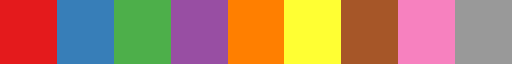

,Response,Complain,color
0,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
2,1,0,"(0.30196078431372547, 0.6862745098039216, 0.29..."
3,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
4,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
...,...,...,...
1488,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1489,1,0,"(0.30196078431372547, 0.6862745098039216, 0.29..."
1490,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1491,0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."


In [31]:
import pandas as pd
import matplotlib.cm as cm
from IPython.display import display

# Assuming you have already defined set1
set1 = cm.Set1.colors

# Displaying the colors of the chosen colormap
display(cm.Set1)

label_df = pd.DataFrame(workdf[['Response', 'Complain']])

# dict
label_dict = {
    (1, 1): set1[0],    # NumDealsPurchases > 2 && Recency > 49
    (0, 1): set1[1],   # NumDealsPurchases <= 2 && Recency > 49
    (1, 0): set1[2],   # NumDealsPurchases > 2 && Recency <= 49
    (0, 0): set1[3]   # NumDealsPurchases <= 2 && Recency <= 49
}

# Applying the dictionary to create the 'color' column
conditions = (label_df['Response'], label_df['Complain'])
label_df['color'] = [label_dict[cond] for cond in zip(*conditions)]

# Displaying the resulting dataframe
label_df

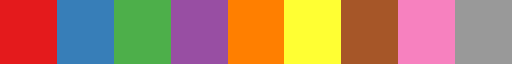

,AcceptedCmp,color
0,Other,"(1, 1, 1)"
1,Other,"(1, 1, 1)"
2,AcceptedCmp1,"(0.8941176470588236, 0.10196078431372549, 0.10..."
3,Other,"(1, 1, 1)"
4,Other,"(1, 1, 1)"
...,...,...
1488,Other,"(1, 1, 1)"
1489,AcceptedCmp5,"(1.0, 0.4980392156862745, 0.0)"
1490,Other,"(1, 1, 1)"
1491,Other,"(1, 1, 1)"


In [32]:
# Set the color for different person wrt AcceptedCmp labels

set1 = cm.Set1.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set1)
#############################################################

# label of interest
interesting_labels = [col for col in workdf.columns if col.startswith('AcceptedCmp')]

label_df = workdf[sorted(interesting_labels)].copy()

def find_feature_name(row):
    for col in label_df.columns:
        if row[col] == 1:
            return col
    return 'Other'

label_df['AcceptedCmp'] = label_df.apply(find_feature_name, axis=1)

label_df = label_df.drop(columns=interesting_labels)


label_dict = {'Other': (1,1,1),
              'AcceptedCmp1': set1[0] ,
              'AcceptedCmp3': set1[2],
              'AcceptedCmp4': set1[3],
              'AcceptedCmp5': set1[4],
              'AcceptedCmp2': set1[1],
}


label_df['color'] = label_df['AcceptedCmp'].map(label_dict)

label_df

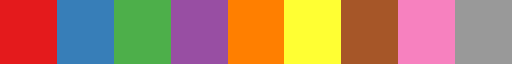

,Response,color
0,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
2,1,"(1.0, 0.4980392156862745, 0.0)"
3,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
4,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
...,...,...
1488,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1489,1,"(1.0, 0.4980392156862745, 0.0)"
1490,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."
1491,0,"(0.596078431372549, 0.3058823529411765, 0.6392..."


In [33]:
# Set the color for different person wrt AcceptedCmp labels

set1 = cm.Set1.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set1)
#############################################################

# label of interest
interesting_labels = 'Response'

label_df = pd.DataFrame(workdf['Response'])

label_dict = {0: set1[3],
              1: set1[4] }

label_df['color'] = label_df['Response'].map(label_dict)

label_df

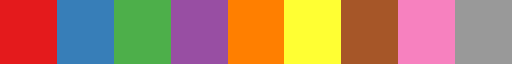

,Recency,color
0,False,"(1, 1, 1)"
1,False,"(1, 1, 1)"
2,False,"(1, 1, 1)"
3,False,"(1, 1, 1)"
4,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."
...,...,...
1488,False,"(1, 1, 1)"
1489,False,"(1, 1, 1)"
1490,False,"(1, 1, 1)"
1491,False,"(1, 1, 1)"


In [221]:

set1 = cm.Set1.colors

######### SHOWING THE COLORS OF THE CHOSEN COLORMAP #########
display(cm.Set1)
#############################################################

# label of interest
interesting_labels = 'Recency'

label_df = pd.DataFrame(workdf['Recency'])

label_dict = {
    True: set1[0],  # Condition > 2
    False: (1,1,1)#set1[1]   # Condition <= 2
}
label_df['Recency'] = label_df['Recency'] > 49

label_df['color'] = label_df['Recency'].map(label_dict)

label_df

## 3 - Preprocessing and full-PCA

### 3.1 - Standardize the features

By observing the dataframe, we notice that features have many differences about scales and range of values. These differences could wrongly influence the PCA, excluding some features just for the dimensionality, so it is necessary to rescale the data. 

We used two scale techniques:

1. **Standard Scaler**: it is the most used data preprocessing method, it standardizes the data re-centering them and normalizing the standard deviation. It is a very useful technique even if, since it redistribute the variance among all the features, it could give more importance to less important features.

1. **Min-Max Scaler**: it distributes the value of each column between a minimum value *m* and a maximum value *M*. It is useful for data with "rank value", and in this case we will use $m=0$ and $M=1$.


In [222]:
# Create Xworkdf_std using the Standard scaler
Xworkdf_std = StandardScaler()
#fit
Xworkdf_std.fit(Xworkdf.values)
#transform
t_Xworkdf_std = Xworkdf_std.transform(Xworkdf.values)

# Create Xworksf_mm using the MinMax scaler
Xworksf_mm = MinMaxScaler()
#fit
Xworksf_mm.fit(Xworkdf.values)
#transform
t_Xworksf_mm = Xworksf_mm.transform(Xworkdf.values)

### 3.2 - First look at the variances (TODO)

### 3.3 - Full PCA

Let's apply PCA. The goals of this type of analysis are:
- reducing the number of features, still preserving most of the dataset's information;
- observing correlation between features and get new information.

Summarizing, we compute the eigenvalues $\lambda$ and the corresponding orthogonal eigenvectors *V* from the covariance matrix. Then the problem needs to be analyzed with respect to the orthogonal basis *V*, where the direction of the axes correspond to the ones of greater variance.

So, the greater is $\lambda_i$ (the *i*-th greater eigenvalue of the covariance matrix), the greater is the variance of the data with respect to the direction of $v_i$ (the *i*-th principal component of the matrix of data), for each *i*=1,...,*n*.

c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


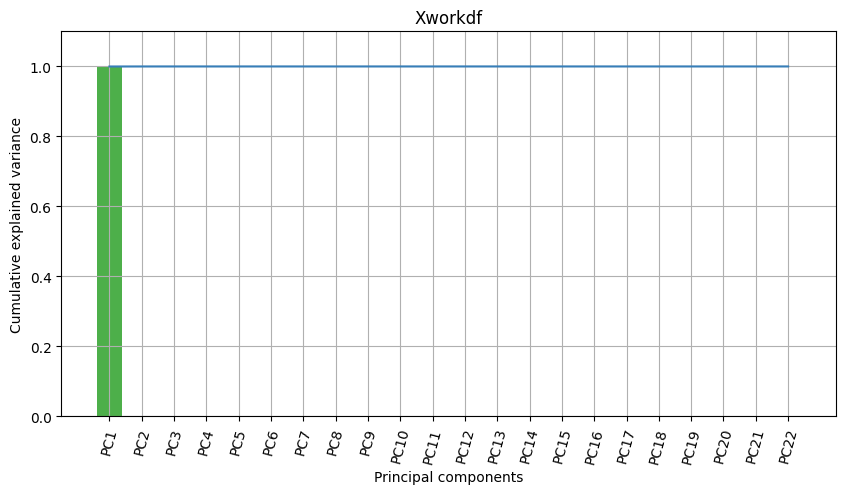

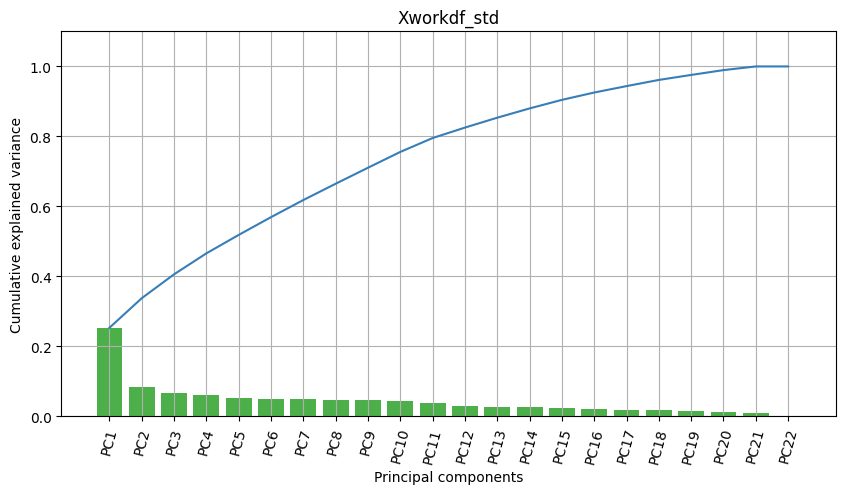

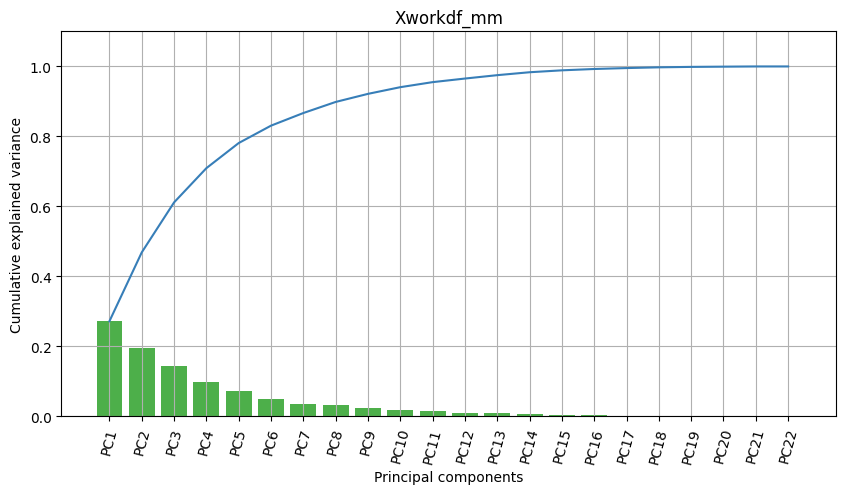

In [223]:
#Apply the “full” PCA1 to the DFs Xworkdf, Xworkdf_std, and Xworkdf_mm
pca_Xworkdf = PCA()
pca_Xworkdf_std = PCA()
pca_Xworkdf_mm = PCA()

pca_Xworkdf.fit(Xworkdf[features].values) 
pca_Xworkdf_std.fit(t_Xworkdf_std)
pca_Xworkdf_mm.fit(t_Xworksf_mm)

# color set
set1 = cm.Set1.colors


#plot the curve of the cumulative explained variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf.explained_variance_ratio_, x = np.arange(22), color=set1[2])
plt.title('Xworkdf')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_std.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf_std.explained_variance_ratio_, x = np.arange(22), color=set1[2])
plt.title('Xworkdf_std')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_std.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_std.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_mm.explained_variance_ratio_), c=set1[1])
plt.bar(height = pca_Xworkdf_mm.explained_variance_ratio_, x = np.arange(22), color=set1[2])
plt.title('Xworkdf_mm')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_mm.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_mm.n_features_)],
           rotation = 75)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

## 4 - Dimensionality Reduction and Interpretation of the PCs

### 4.1 - Selection and display of PCs

We have to select *m* PCs such that $m=min(m',5)$, where *m'* is the minimum number of PCs that explains 33% of variance.

In both cases of rescale we obtain 2 as the minimum number of PCs that explains 33% of variance.

More precisely, with standard scaled data we explain 33.78% of total variance, while with min-max scaled data we explain the 46.87%.

In [224]:
m_star_std = 2 # m' of Xworkdf_std
m_star_mm = 2 # m' of Xworkdf_mm

m_std = min(m_star_std,5)
m_mm = min(m_star_mm,5)

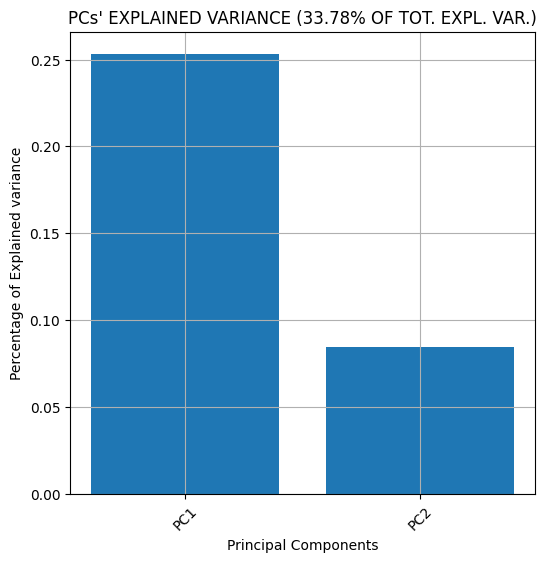

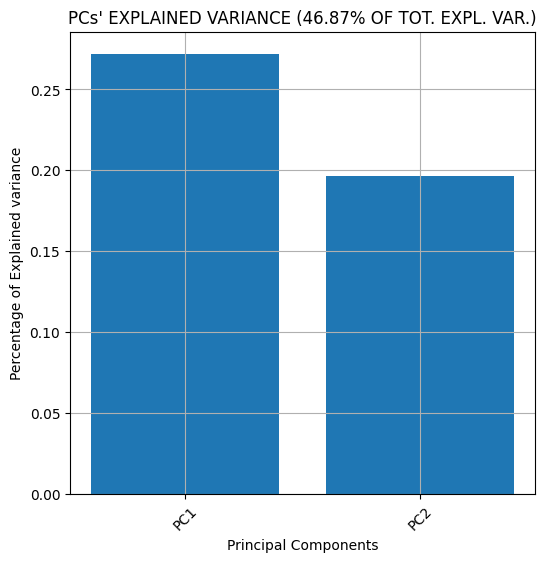

In [225]:
# PCA
pca_std = PCA(n_components = m_std)
pca_mm = PCA(n_components = m_mm)

# Fit the PCA of StandarScaler data
pca_std.fit(t_Xworkdf_std)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_std+1), pca_std.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_std}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_std+1), 
           labels=[f'PC{i}' for i in range(1,m_std+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

# Fit the PCA of MinMaxScaler data
pca_mm.fit(t_Xworksf_mm)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_mm+1), pca_mm.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_mm}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_mm+1), 
           labels=[f'PC{i}' for i in range(1,m_mm+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

### 4.2 - Interpretation of the PCs

We consider relevant for the analysis only the contribute of the features over a prefixed threshold $\epsilon= \sqrt{1/n}$, where $n$ is the number of features.


#### 4.2.1 - Interpretation of the PCs for StandardScaler data

We look at the first two principal components:
1. the first has **high positive** values for the features *'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases'*, whose represent a client with high power of purchase, and it has **high negative** values for the features *'Kidhome', 'NumWebVisitsMonth'*

1. the second component has **high positive** values for the features *'Year_Birth', 'Marital_Status_Single'*, whose can represent a young client, and **high negative** values for *'Education', 'Teenhome', 'NumWebPurchases'*, whose can represent a client with a family and a high education.

c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


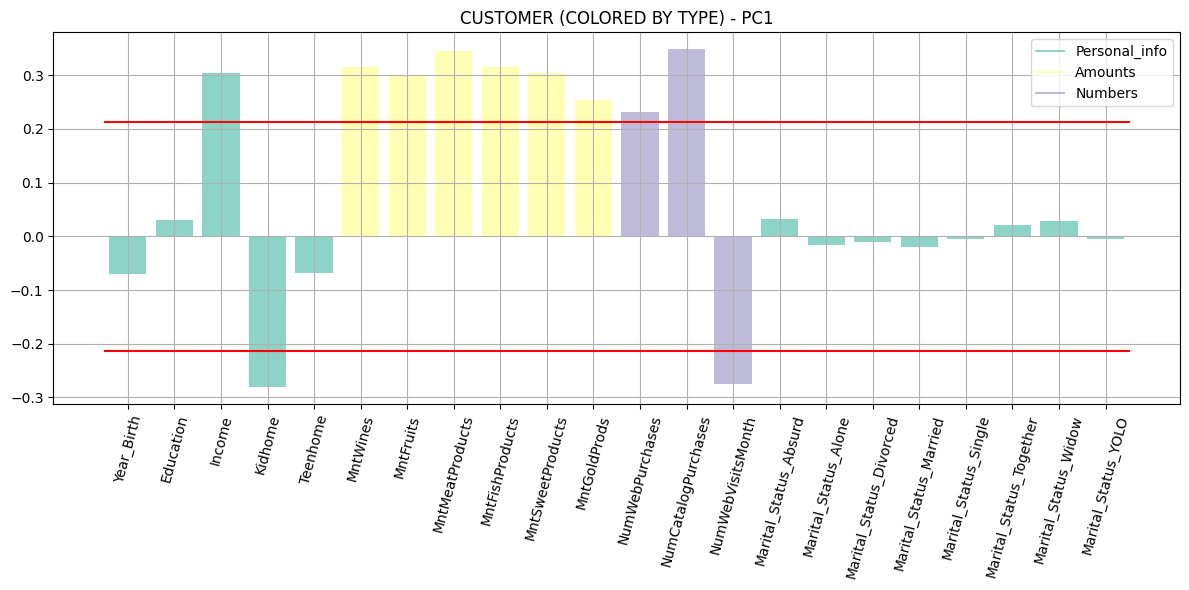


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



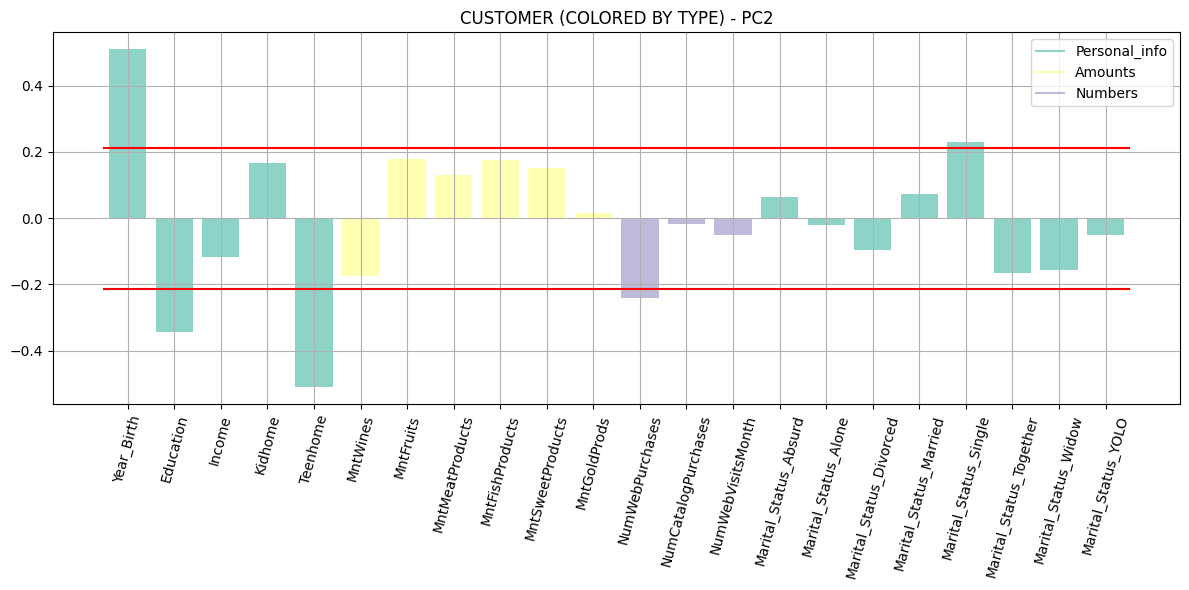


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Year_Birth', 'Marital_Status_Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Education', 'Teenhome', 'NumWebPurchases']
*********************************************



In [226]:
from matplotlib.lines import Line2D
# DEFINE EPSILON
eps = np.sqrt(1 / pca_std.n_features_)

# DEFINE THE LIST OF CUSTOMER COLORS W.R.T. THE CUSTOMER TYPES AND THE CUSTOMER CATEGORIES
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# MAKE A CUSTOM LEGEND
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_std):
    # MAKE THE BARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :], color= cat_color)
    
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_std.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'CUSTOMER (COLORED BY TYPE) - PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE CUSTOMER WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [227]:
pc_names_std = ['Kid and web visits (-) VS High spending (+)',
                'Family & High education (-) VS Young clients (+)'
               ]

#### 4.2.1 - Interpretation of the PCs for MinMaxScaler data

1. The first component has **high positive** value only for the feature *'Marital_Status_Married'*, so it definitely refers to a married client, and it has **high negative** values for *'Marital_Status_Single', 'Marital_Status_Together'*, so the exact opposite of the positive value.
1. The second component has **high positive** value for the feature *'Marital_Status_Single'*, representing a single client, and **high negative** value for the feature *Marital_Status_Together*, so also in this case we have two opposite status.

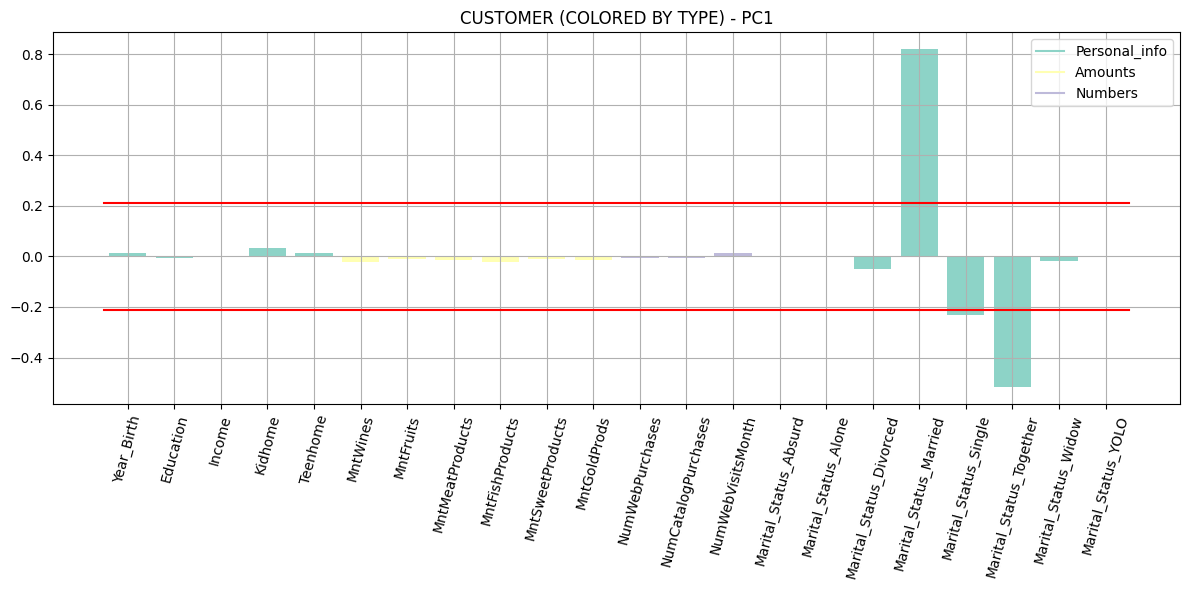


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Marital_Status_Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Marital_Status_Single', 'Marital_Status_Together']
*********************************************



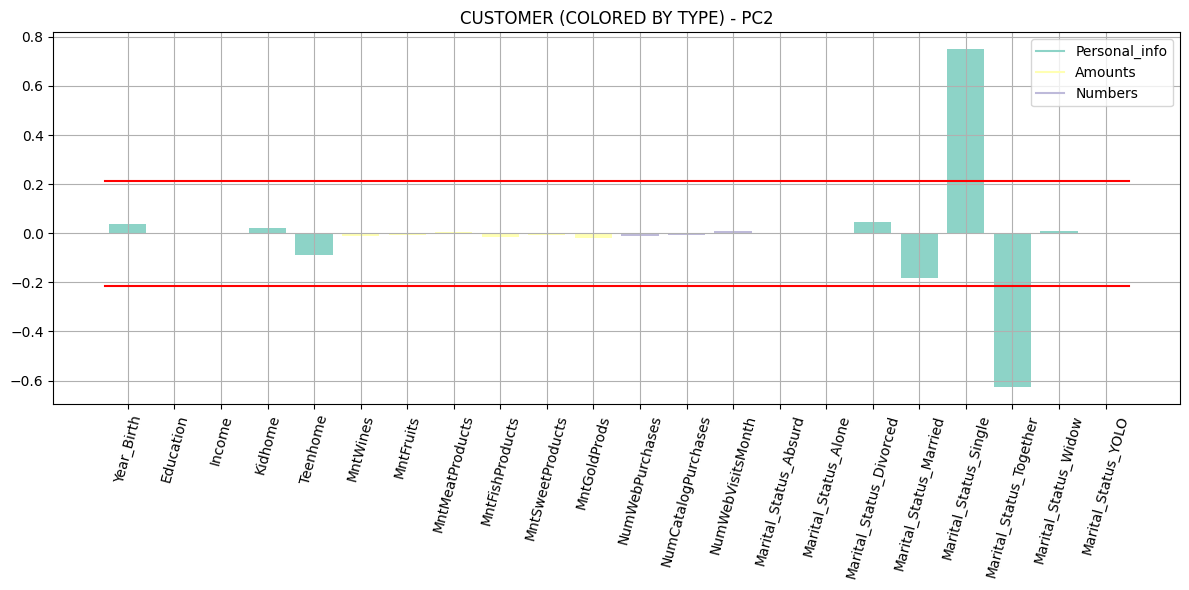


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Marital_Status_Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Marital_Status_Together']
*********************************************



In [228]:
# DEFINE EPSILON
eps = np.sqrt(1 / pca_mm.n_features_)

# DEFINE THE LIST OF CUSTOMER COLORS W.R.T. THE CUSTOMER TYPES AND THE CUSTOMER CATEGORIES
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# MAKE A CUSTOM LEGEND
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_mm):
    # MAKE THE BARPLOT WITH CUSTOMER TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[ii, :], color=cat_color)
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_mm.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'CUSTOMER (COLORED BY TYPE) - PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE CUSTOMER WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_mm.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [229]:
pc_names_mm = ['Together & Single (-) VS Married (+)',
               'Together (-) VS Single (+)']

### 4.3 - Score graphs

#### 4.3.1 - Score graph for StandardScaler data

The results from the score graph, as expected, are not really useful. That was predictable because with two components we only explained 33.78% of the total variance, so we lost much of the information and also the components that we considered did not seem very correlated.
All customers appear sparse in the space, even if we can notice some parts with more density. For example, most of the clients that have a kid or visit the website appear to be young.

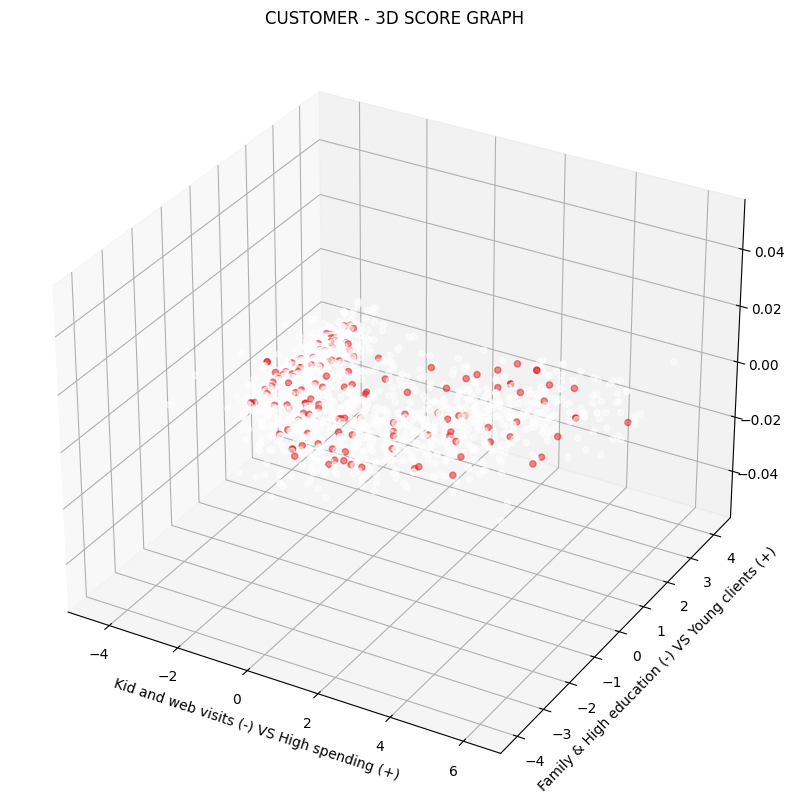

In [230]:
# PCA transform 
Yworkdf_std = pca_std.transform(t_Xworkdf_std)

# 3D Score graph
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], c=label_df['color'].values, alpha=0.5)

ax.set_xlabel(pc_names_std[0])
ax.set_ylabel(pc_names_std[1])

plt.title('CUSTOMER - 3D SCORE GRAPH')
plt.grid()
plt.show()

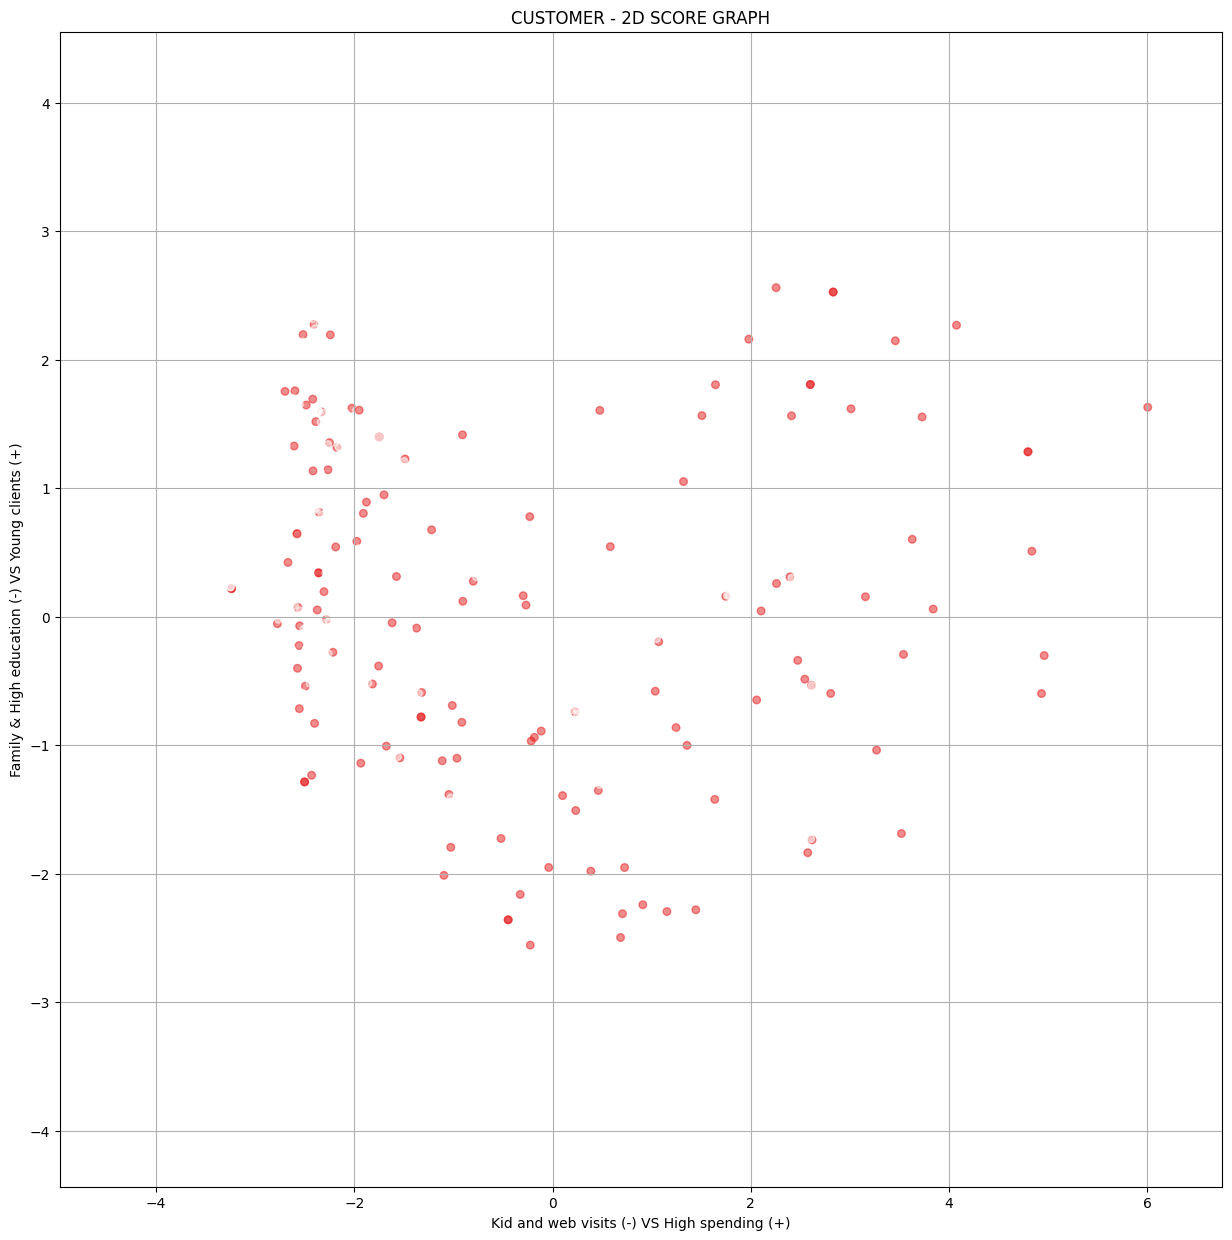

In [231]:
# 2D Score graph
sg = plt.figure(figsize=(15, 15))
as_sg = sg.add_subplot(111)

as_sg.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], c=label_df['color'].values, alpha=0.5,s=30)

as_sg.set_xlabel(pc_names_std[0])
as_sg.set_ylabel(pc_names_std[1])
plt.title('CUSTOMER - 2D SCORE GRAPH')
plt.grid()
plt.show()


#### 4.3.2 - Score graph for MinMaxScaler data

Results appear to be way better with this scale. We clearly see 4 group of points, and theyu all seem coherent to the name and the components they are represented by. 

On the low-right side, we see married-together clients, on the low-left the clients who are together but not married, in the top left the clients who are single and in the center the (only) less clear group of clients.

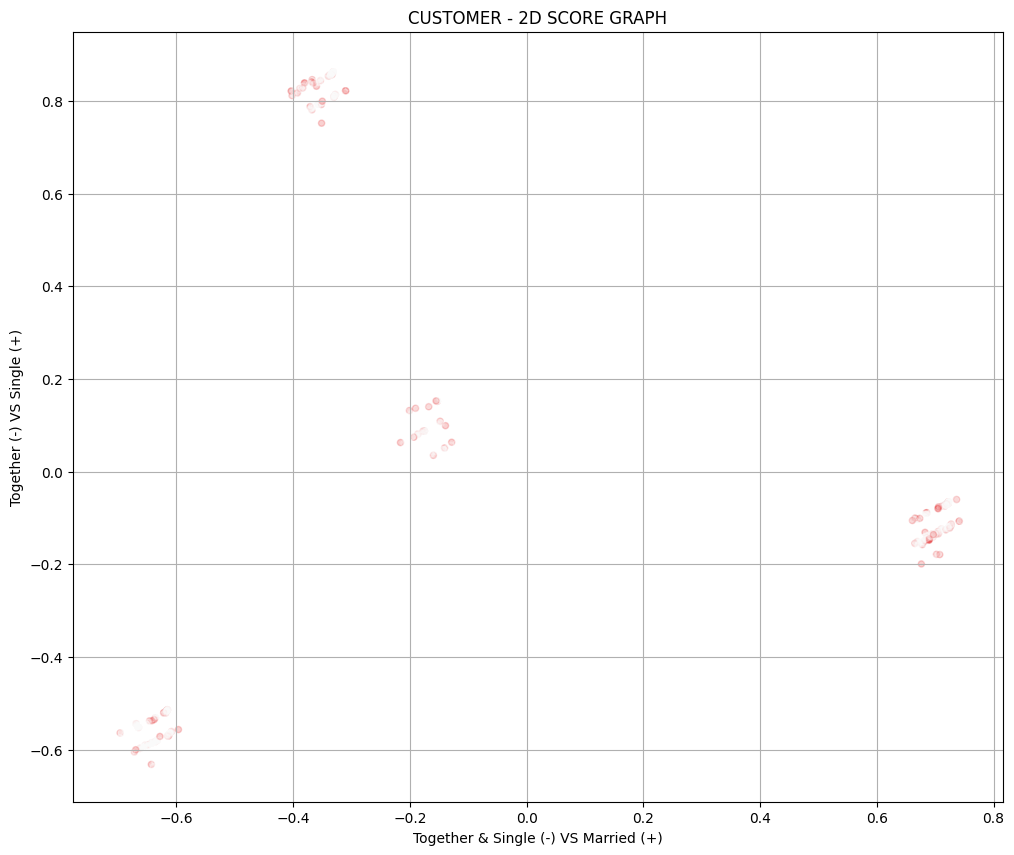

In [232]:
# PCA transform
Yworkdf_mm = pca_mm.transform(t_Xworksf_mm)

# 2D Score graph
sg = plt.figure(figsize=(12, 10))
as_sg = sg.add_subplot(111)

as_sg.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=20, c=label_df['color'].values, alpha=0.2)

as_sg.set_xlabel(pc_names_mm[0])
as_sg.set_ylabel(pc_names_mm[1])
plt.title('CUSTOMER - 2D SCORE GRAPH')
plt.grid()
plt.show()


### 4.4 - More accurate score graphs

### 4.5 - Analysis and comment

## 5 - K-Means

Let's apply the *K-Means* algorithm to the dataset.
This algorithm computes clusters based on the similarity between objects using Euclidean distance. It can be useful to identify an useful structure of the data.

To select the optimal number $k$ for the k-means, we use the best silhouette coefficient. 

To compute it, we calculate k-means for all the given k values, then we compute the silhouette coefficient: $k^∗ = argmax_k \frac{1}{N} \sum_{x∈S} s(x)$

For the **standard scaled** data we find $k=3$ as the best coefficient, while for **min-max scaled** we find $k=4**

In [233]:
km_list_std = []
silcoeff_list_std = []
k_list_std = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_std)):
    print(f'****************** START k-MEANS WITH k={k_list_std[i]} ******************')
    print('Computing...')
    km_list_std.append(KMeans(n_clusters=k_list_std[i], n_init=3, random_state=random_state))
    km_std = km_list_std[i]
    km_std.fit(Yworkdf_std)
    silcoeff_list_std.append(silhouette_score(Yworkdf_std,km_std.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_std[i]} ******************')
    print('\n')
    

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list_std[i_best_std]
km_std = km_list_std[i_best_std]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_std)} --> k = {k_std}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************


****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************


****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************


****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************


****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************


****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************


****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************


****************** START k-MEANS WITH k=10 ************

In [234]:
print(silcoeff_list_std)

[0.4576925708403603, 0.40643543479492344, 0.37949133758044107, 0.3916899571563788, 0.3672205296082234, 0.3679833948958105, 0.3471913824649027, 0.33921945872359244]


In [235]:
km_list_mm = []
silcoeff_list_mm = []
k_list_mm = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_mm)):
    print(f'****************** START k-MEANS WITH k={k_list_mm[i]} ******************')
    print('Computing...')
    km_list_mm.append(KMeans(n_clusters=k_list_mm[i], n_init=3, random_state=random_state))
    km_mm = km_list_mm[i]
    km_mm.fit(Yworkdf_mm)
    silcoeff_list_mm.append(silhouette_score(Yworkdf_mm,km_mm.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_mm[i]} ******************')
    print('\n')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list_mm[i_best_mm]
km_mm = km_list_mm[i_best_mm]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_mm)} --> k = {k_mm}') 
print('**************************************************************')



****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************


****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************


****************** START k-MEANS WITH k=5 ******************
Computing...


****************** END k-MEANS WITH k=5 ******************


****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************


****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************


****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************


****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************


****************** START k-MEANS WITH k=10 ******************
Computing...
****************** END k-MEANS WITH k=10 ******************




****************** RESULTS OF THE SEARCH... ******************
BEST SILHOUETTE SCORE: 0.941037931702606 --> k = 4
**************************************************************


In [236]:
print(silcoeff_list_mm)

[0.8437449495167302, 0.941037931702606, 0.8061368088931893, 0.6176210837836961, 0.5173284385665567, 0.4371021489368528, 0.4852888999077458, 0.607499000964516]


## 6 - Clusters and Centroid Interpretation and Visualization

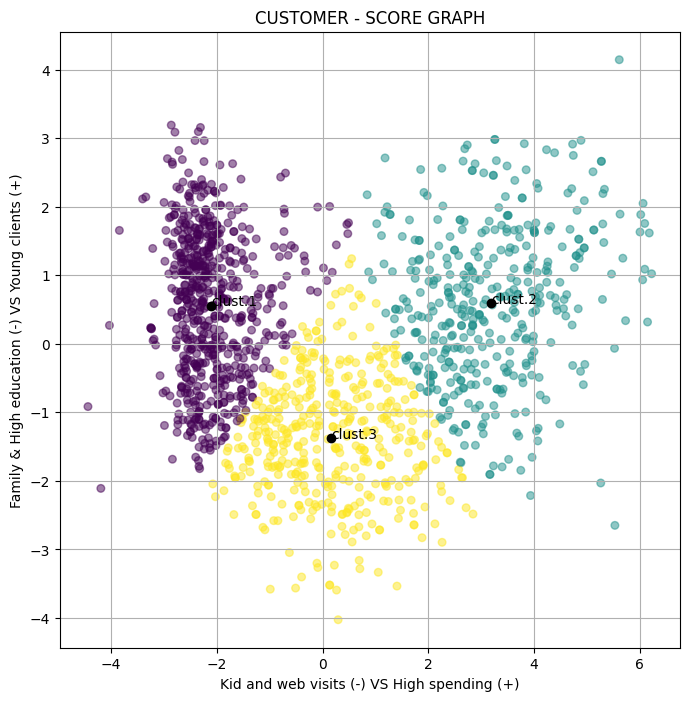

In [237]:
# Score graph with centroids for MinMaxScaler data
labels_std = km_std.labels_

sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1],s=30,c=km_std.labels_, alpha=0.5)
ax_sg_km.scatter(km_std.cluster_centers_[:,0], km_std.cluster_centers_[:,1], c='black')
for kk in range(k_std):
    ax_sg_km.text(km_std.cluster_centers_[kk, 0], km_std.cluster_centers_[kk, 1], f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_std[0])
ax_sg_km.set_ylabel(pc_names_std[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

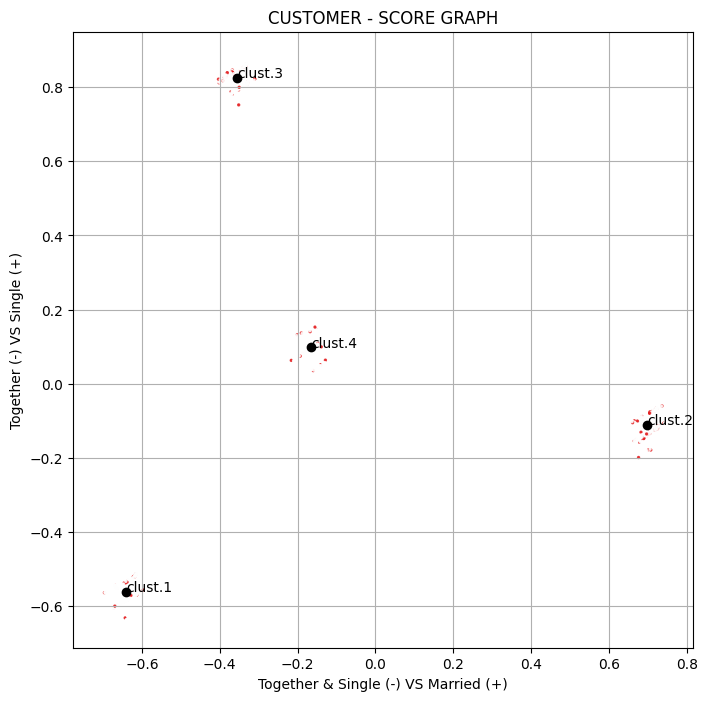

In [238]:
# Score graph with centroids for MinMaxScaler data
labels_mm = km_mm.labels_

sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=2,c=label_df['color'].values ,alpha=0.8)
ax_sg_km.scatter(km_mm.cluster_centers_[:,0], km_mm.cluster_centers_[:,1], c='black')
for kk in range(k_mm):
    ax_sg_km.text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_mm[0])
ax_sg_km.set_ylabel(pc_names_mm[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

In [239]:
k_std

3

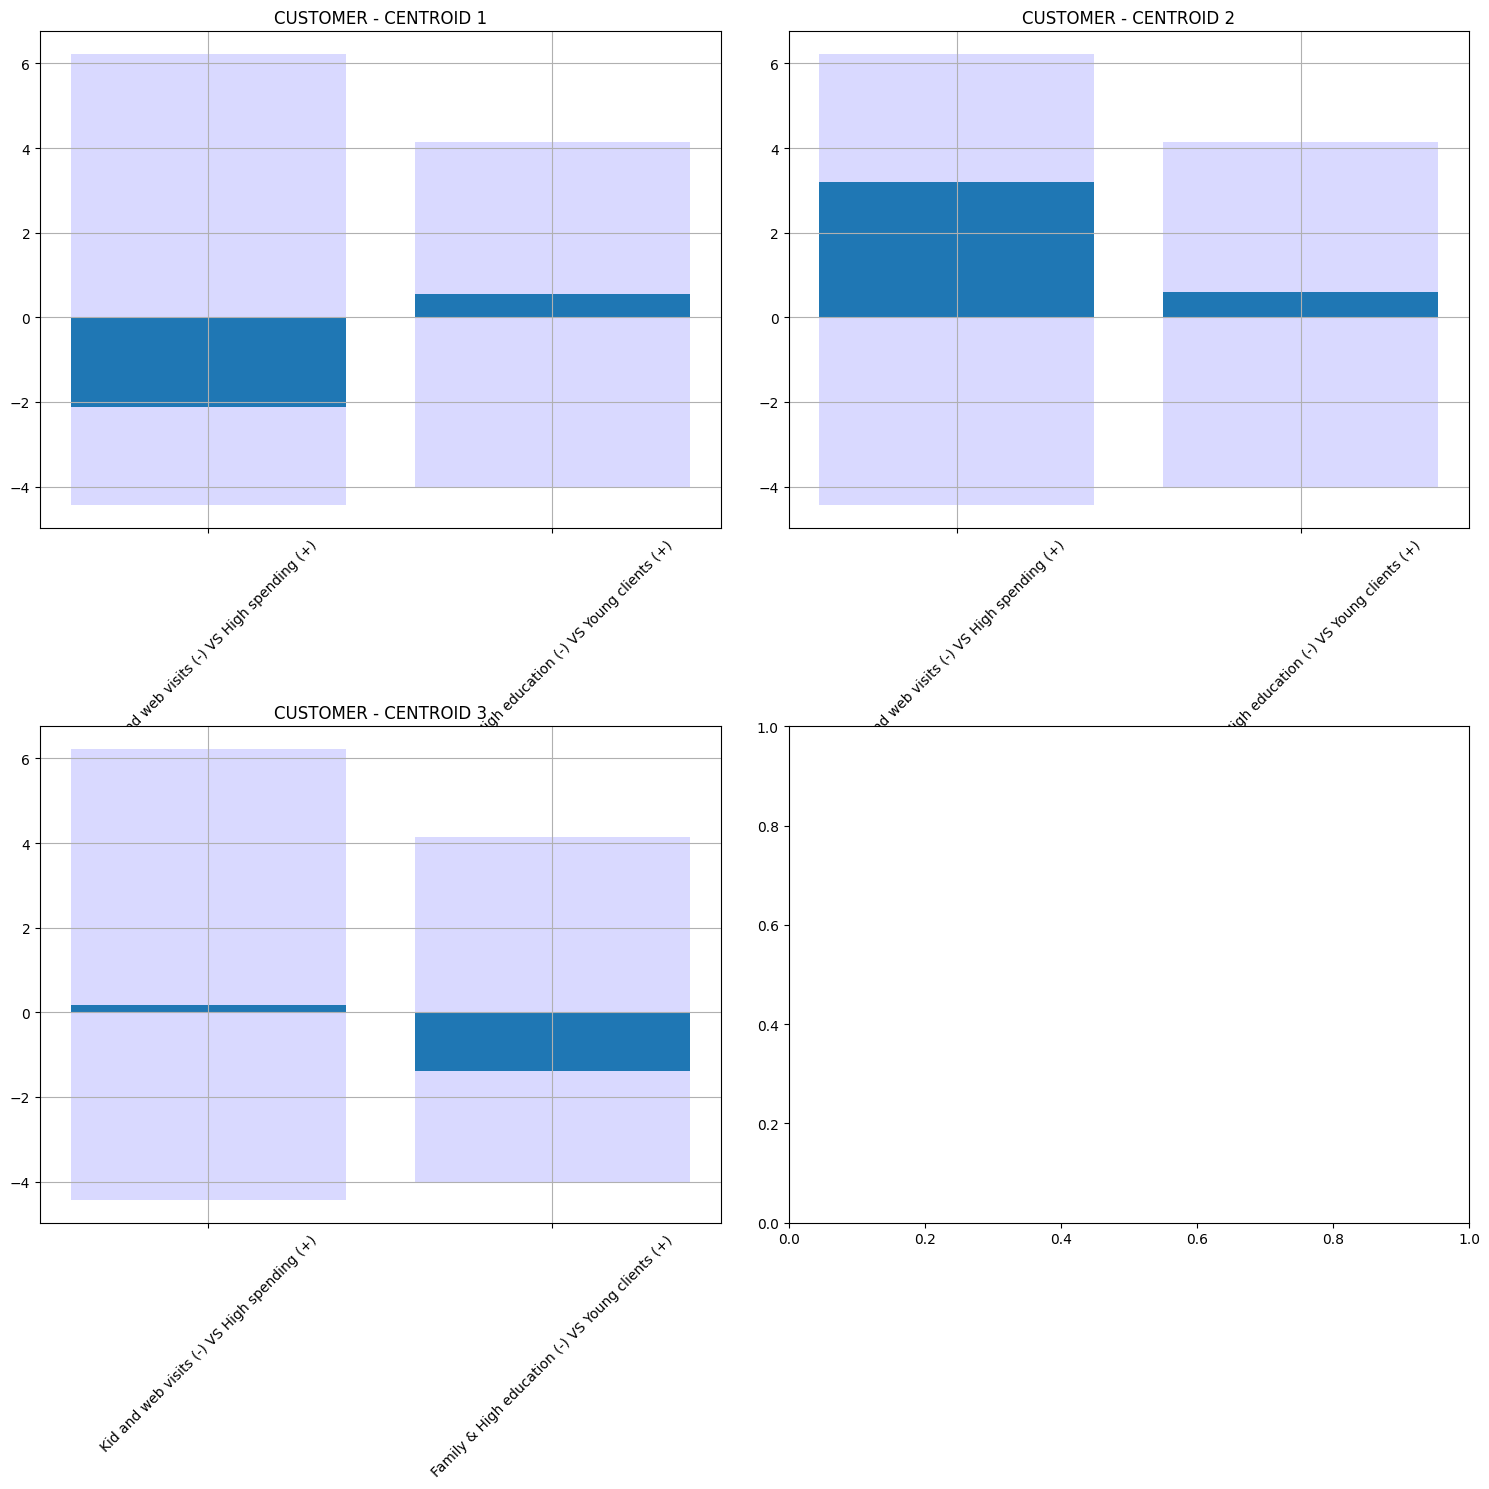

In [240]:
maxs_y = Yworkdf_std.max(axis=0) 
mins_y = Yworkdf_std.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(2,2, figsize=(15, 15))

ax_centroids = ax_centroids.flatten()

for ii in range(k_std):
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(km_std.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_std, rotation = 45)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')
plt.subplots_adjust(wspace=0.1, hspace=0.4)



In [241]:
cluster_names_std = ['Other', #cliente non fidelizzato
                     'Premium Customer',
                     'Active Family Customer',
                     ]

In [242]:
k_mm

4

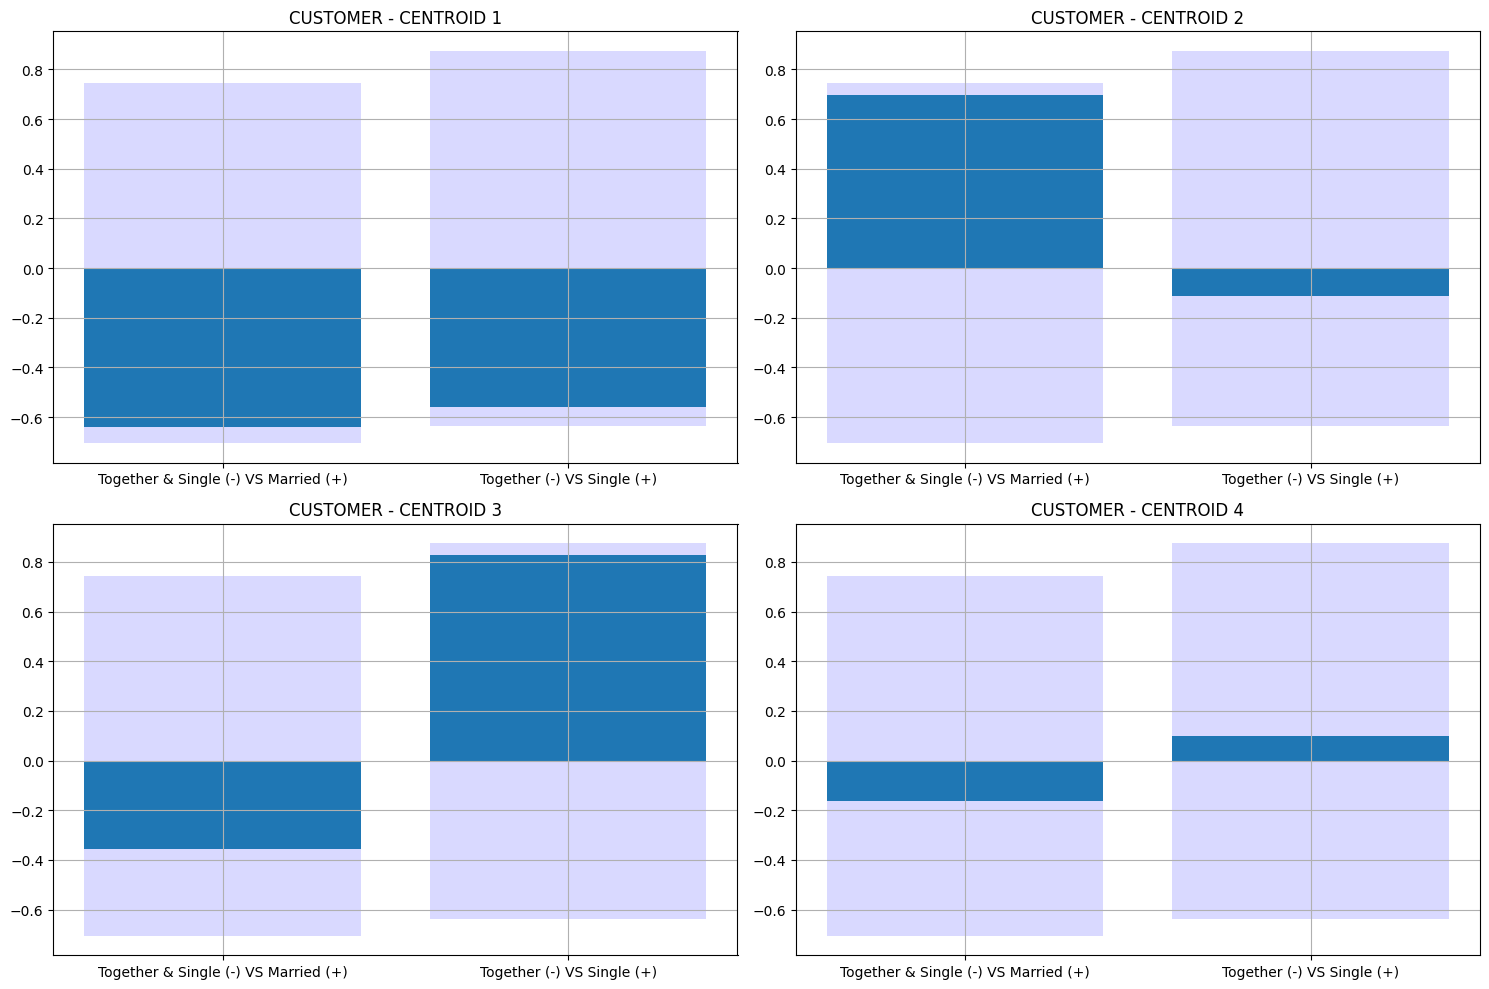

In [243]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Yworkdf_mm.max(axis=0) 
mins_y = Yworkdf_mm.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(2,2, figsize=(15, 10))

ax_centroids = ax_centroids.flatten()

for ii in range(k_mm):
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), km_mm.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(km_mm.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_mm)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

In [244]:
cluster_names_mm = ['In-couple Customer',
                    'Married Customer',
                    'Single Customer',
                    'Other'
                    ]

## 7 - Clusters and Centroid Evaluation
- For both the DFs, perform an internal and an external evaluation of the clusterings obtained
  - Measure the silhouette scores of the clusters (internal evaluation);
  - perform an external evaluation of the clusters analyzing and plotting the distribution of the labels (view lesson 22/12/23)
  - Comment the results. Compare the results obtained from Xworkdf std and Xworkdf mm and comment them

In [245]:
silscores = silhouette_samples(Yworkdf_std, km_std.labels_)
cluster_silscores = [np.mean (silscores [km_std.labels_ == kk]) for kk in range (k_std) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_std)]), index=cluster_names_std + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
Other,0.511530
Premium Customer,0.452964
Active Family Customer,0.381796
Global,0.457693


In [246]:
silscores = silhouette_samples(Yworkdf_mm, km_mm.labels_)
cluster_silscores = [np.mean (silscores [km_mm.labels_ == kk]) for kk in range (k_mm) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_mm)]), index=cluster_names_mm + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
In-couple Customer,0.943060
Married Customer,0.946352
Single Customer,0.938180
Other,0.926774
Global,0.941038


In [247]:
#EXTERNAL EVALUATION ????